In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from fastkde import KDE
from gaussianmixture import GaussianMixture
from tqdm import tqdm_notebook as tqdm
import scipy.stats
import h5py
import os
from matplotlib2tikz import save
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\geldered\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Show KDE with confidence intervals univariate case

In [2]:
# Parameters
seed = 0
ndatapoints = 500
confidence = 0.95
nrepeat = 1000  # Number of repeats for the bootstrap
npdf = 101
overwrite = False

In [212]:
# Create object for generating data from a Gaussian mixture
xlim = [-3, 3]
gm = GaussianMixture([-1, 1], [0.5, 0.3])
gmb = GaussianMixture([-0.5, 0.5, 1.5], [0.3, 0.5, 0.3])
(xpdf,), ypdf = gm.pdf(minx=[xlim[0]], maxx=[xlim[1]], n=npdf)
_, ypdfb = gmb.pdf(minx=[xlim[0]], maxx=[xlim[1]], n=npdf)

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


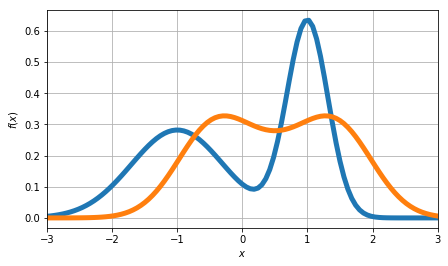

In [213]:
# Make a figure of the distribution and export to tikz
f, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(xpdf, ypdf, lw=5)
ax.plot(xpdf, ypdfb, lw=5)
ax.grid(True)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_xlim(xlim)
save(os.path.join('..', '20181002 Completeness question', 'figures', 'true_pdf.tikz'),
     figureheight='\\figureheight', figurewidth='\\figurewidth')

### Plug-in method

The uncertainty can be approximated by $\sqrt{\frac{\mu_K}{n h^d} p(x)}$ with:

- $\mu_K$ is a constant that only depends on the chosen Kernel: $\mu_K = \int K(x)^2 dx$ where the integral is taken over all $x$.
- $n$ represents the number of datapoints
- $h$ denotes the bandwidth
- $d$ denotes the dimension of $x$
- $p(x)$ is the real probability density at $x$

In reality, the uncertainty also depends on terms that are proportional with higher order terms of $h$. It is assumed that $h$ is sufficiently small such that these terms can be ignored.

The plug-in method simply replaces $p(x)$ with the estimated probability density function $\hat{p}(x)$, where $\hat{p}(x)$ is estimated using Kernel Density Estimation.

In [5]:
# Use the plug-in method
np.random.seed(seed)
x = gm.generate_samples(ndatapoints)
kde = KDE(data=x)
kde.compute_bw()  # Compute the bandwidth using one-leave-out cross validation
bandwidth = kde.bw  # Store the bandwidth for later usage
print("Bandwidth: {:.5f}".format(bandwidth))
ypdf_estimated = kde.score_samples(xpdf)
low_plugin, up_plugin = kde.confidence_interval(xpdf, confidence=confidence)

Bandwidth: 0.23288


### Bootstrap

With bootstrapping, we create $N$ artifical datasets by taking each time $n$ datapoints from the original dataset with replacement. In total, the real PDF $p(x)$ is $N$ times estimated. 

The first bootstrap method (bootstrap and plug-in approach) estimates the variance of the estimated probability at $x$ using the $N$ estimates. This variance is used to compose the confidence intervals.

The second bootstrap method (simply called Bootstrap) directly composes the confedence intervals by taking the appropriate percentiles of the estimated probabilities at each value of $x$.  

In [6]:
# Use the bootstrap method for determining the confidence interval
np.random.seed(seed)
filename = os.path.join("hdf5", "pdfs_bootstrap.hdf5")
if overwrite or not os.path.exists(filename):
    pdfs_bootstrap = np.zeros((nrepeat, len(xpdf)))
    for i in tqdm(range(nrepeat)):
        kde = KDE(data=x[np.random.choice(len(x), size=len(x), replace=True)], bw=bandwidth)
        pdfs_bootstrap[i] = kde.score_samples(xpdf)
        
    # Store the PDFs
    with h5py.File(filename, "w") as f:
        f.create_dataset("pdfs", data=pdfs_bootstrap)
else:
    with h5py.File(filename, "r") as f:
        pdfs_bootstrap = f["pdfs"][:]
        
# The first bootstrap method (bootstrap and plug-in approach)
std = np.std(pdfs_bootstrap, axis=0)
zvalue = scipy.stats.norm.ppf(confidence/2+0.5)
low_bootstrap1 = ypdf_estimated - zvalue*std  # "Bootstrap and plug-in approach"
up_bootstrap1 = ypdf_estimated + zvalue*std

# The second bootstrap method (simply called "bootstrap")
deviation = np.percentile(np.abs(pdfs_bootstrap - np.mean(pdfs_bootstrap, axis=0)), confidence*100, axis=0)
low_bootstrap2 = ypdf_estimated - deviation
up_bootstrap2 = ypdf_estimated + deviation

In [7]:
# Perform the KDE many times to see the real uncertainty
np.random.seed(seed)
pdfs = np.zeros((nrepeat, len(xpdf)))
filename = os.path.join("hdf5", "pdfs.hdf5")
if overwrite or not os.path.exists(filename):
    for i in tqdm(range(nrepeat)):
        x = gm.generate_samples(ndatapoints)
        kde = KDE(data=x, bw=bandwidth)
        kde.compute_bw(min_bw=0.05, max_bw=0.5)
        pdfs[i] = kde.score_samples(xpdf)
        
    # Store the PDFs
    with h5py.File(filename, "w") as f:
        f.create_dataset("pdfs", data=pdfs)
else:
    with h5py.File(filename, "r") as f:
        pdfs = f["pdfs"][:]

low_real = np.percentile(pdfs, (1-confidence)*50, axis=0)
up_real = np.percentile(pdfs, (1+confidence)*50, axis=0)

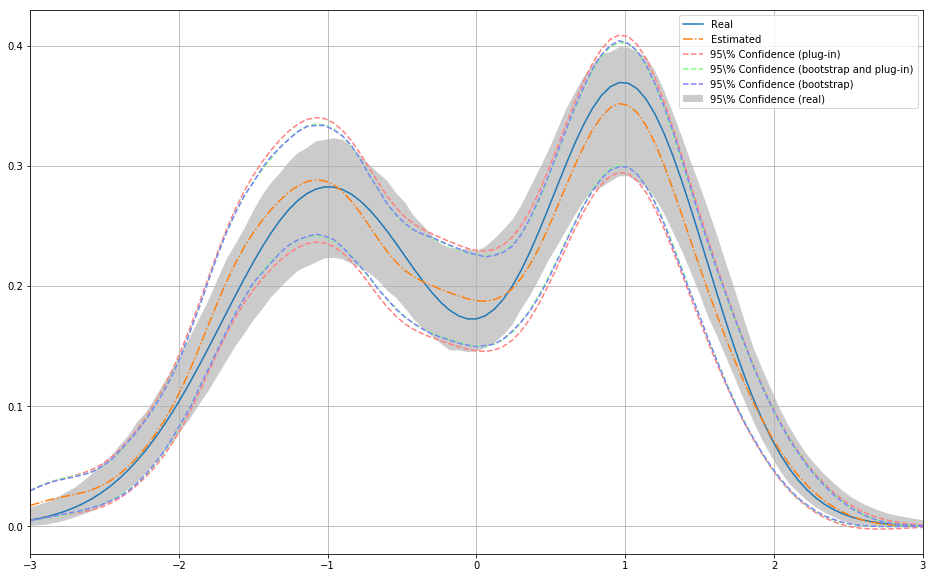

In [8]:
f, ax = plt.subplots(1, 1, figsize=(16, 10))

# Plot the results
plt_pdf, = ax.plot(xpdf, ypdf)
plt_estimated, = ax.plot(xpdf, ypdf_estimated, '-.')
plt_plugin = ax.plot(np.array([xpdf, xpdf]).T, np.array([low_plugin, up_plugin]).T, '--', color='#ff8080')
plt_bootstrap1 = ax.plot(np.array([xpdf, xpdf]).T, np.array([low_bootstrap1, up_bootstrap1]).T, '--', color='#80ff80')
plt_bootstrap2 = ax.plot(np.array([xpdf, xpdf]).T, np.array([low_bootstrap2, up_bootstrap2]).T, '--', color='#8080ff')
plt_realconf = ax.fill_between(xpdf, low_real, up_real, facecolor=[.6, .6, .6], alpha=.5)
ax.legend([plt_pdf, plt_estimated, plt_plugin[0], plt_bootstrap1[0], plt_bootstrap2[0], plt_realconf], 
          ['Real', 'Estimated', '{:.0f}\% Confidence (plug-in)'.format(confidence*100),
           '{:.0f}\% Confidence (bootstrap and plug-in)'.format(confidence*100),
           '{:.0f}\% Confidence (bootstrap)'.format(confidence*100),
           '{:.0f}\% Confidence (real)'.format(confidence*100)])
ax.grid(True)
_ = ax.set_xlim(xlim)  # The "_ =" suppresses the output

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


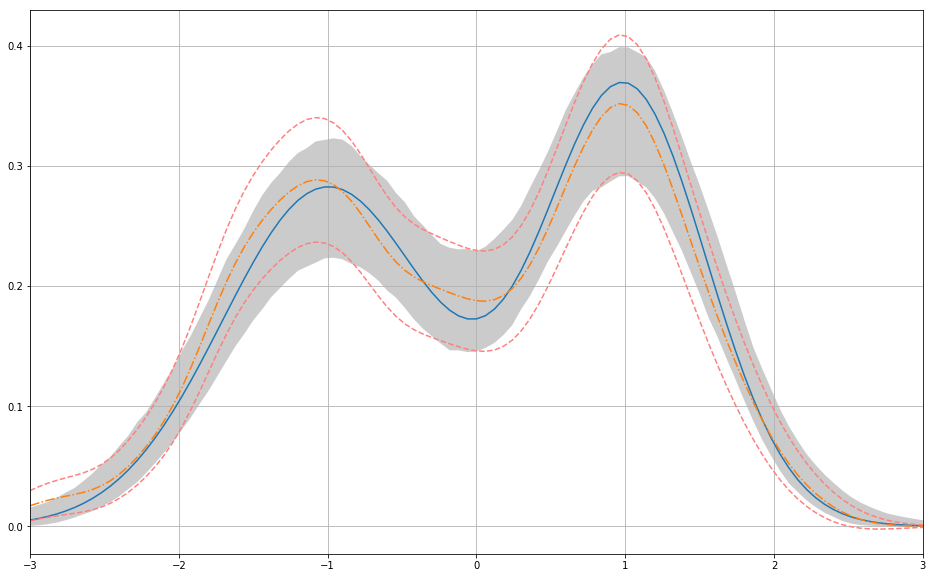

In [9]:
f, ax = plt.subplots(1, 1, figsize=(16, 10))

# Plot the results
ax.plot(xpdf, ypdf)
ax.plot(xpdf, ypdf_estimated, '-.')
ax.plot(np.array([xpdf, xpdf]).T, np.array([low_plugin, up_plugin]).T, '--', color='#ff8080')
ax.fill_between(xpdf, low_real, up_real, facecolor=[.6, .6, .6], alpha=.5)
ax.grid(True)
_ = ax.set_xlim(xlim)  # The "_ =" suppresses the output
save(os.path.join('..', 'progress_reports', 'report10', 'confidence_interval.tikz'),
     figureheight='\\figureheight', figurewidth='\\figurewidth')

# Show confidence interval multivariate case (2-d)

In [10]:
# Parameters
seed = 0
ndatapoints = 500
confidence = 0.95
nrepeat = 1000  # Number of repeats for the bootstrap
factor_of_max = 0.1  # Control height of PDF for contour plot
npdf = 101
overwrite = False

In [11]:
# Create object for generating data from a Gaussian mixture
x1lim, x2lim = [-3, 3], [-3, 3]
gm2 = GaussianMixture([[-1, -1], [1, 1]], [[[0.5, 0.25], [0.25, 0.4]], [[0.5, -0.25], [-0.25, 0.4]]])
(x1pdf, x2pdf), ypdf = gm2.pdf(minx=[x1lim[0], x2lim[0]], maxx=[x1lim[1], x2lim[1]], n=npdf)

In [12]:
# Use the plug-in method
np.random.seed(seed)
x = gm2.generate_samples(ndatapoints)
kde = KDE(data=x)
kde.compute_bw()  # Compute the bandwidth using one-leave-out cross validation
bandwidth = kde.bw  # Store the bandwidth for later usage
print("Bandwidth: {:.5f}".format(bandwidth))
xpdf2 = np.transpose(np.array([x1pdf, x2pdf]), [1, 2, 0])
ypdf_estimated = kde.score_samples(xpdf2)
low_plugin2, up_plugin2 = kde.confidence_interval(xpdf2, confidence=confidence)

Bandwidth: 0.25698


In [13]:
# Use the bootstrap method for determining the confidence interval
np.random.seed(seed)
filename = os.path.join("hdf5", "pdfs_bootstrap2.hdf5")
pdfs_bootstrap2 = np.zeros((nrepeat, len(x1pdf), len(x2pdf)))

if overwrite or not os.path.exists(filename):
    for i in tqdm(range(nrepeat)):
        kde = KDE(data=x[np.random.choice(len(x), size=len(x), replace=True)], bw=bandwidth)
        pdfs_bootstrap2[i] = kde.score_samples(xpdf2)

    # Store the PDFs
    with h5py.File(filename, "w") as f:
        f.create_dataset("pdfs", data=pdfs_bootstrap2)
else:
    with h5py.File(filename, "r") as f:
        pdfs_bootstrap2 = f["pdfs"][:]
        
std = np.std(pdfs_bootstrap2, axis=0)
zvalue = scipy.stats.norm.ppf(confidence/2+0.5)
low_bootstrap1_2 = ypdf_estimated - zvalue*std  # "Bootstrap and plug-in approach"
up_bootstrap1_2 = ypdf_estimated + zvalue*std
deviation = np.percentile(np.abs(pdfs_bootstrap2 - np.mean(pdfs_bootstrap2, axis=0)), confidence*100, axis=0)
low_bootstrap2_2 = ypdf_estimated - deviation
up_bootstrap2_2 = ypdf_estimated + deviation

In [14]:
# Perform the KDE many times to see the real uncertainty
np.random.seed(seed)
filename = os.path.join("hdf5", "pdfs2.hdf5")
pdfs2 = np.zeros((nrepeat, len(x1pdf), len(x2pdf)))

if overwrite or not os.path.exists(filename):
    for i in tqdm(range(nrepeat)):
        x = gm2.generate_samples(ndatapoints)
        kde = KDE(data=x)
        kde.compute_bw(min_bw=0.05, max_bw=0.5)
        pdfs2[i] = kde.score_samples(xpdf2)

    # Store the PDFs
    with h5py.File(filename, "w") as f:
        f.create_dataset("pdfs", data=pdfs2)
else:
    with h5py.File(filename, "r") as f:
        pdfs2 = f["pdfs"][:]
        
low_real2 = np.percentile(pdfs2, (1-confidence)*50, axis=0)
up_real2 = np.percentile(pdfs2, (1+confidence)*50, axis=0)

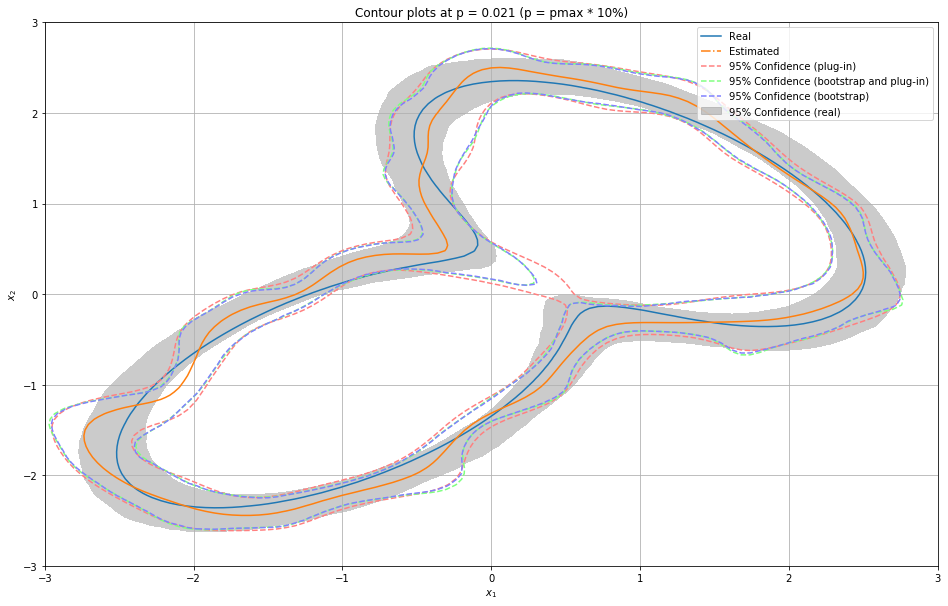

In [15]:
f, ax = plt.subplots(1, 1, figsize=(16, 10))

# Plot the result of the plug-in method
ycontour = np.max(ypdf)*factor_of_max
plt.contour(x1pdf, x2pdf, ypdf, ycontour, colors=plt_pdf.get_color())
plt.contour(x1pdf, x2pdf, ypdf_estimated, ycontour, colors=plt_estimated.get_color())
plt.contour(x1pdf, x2pdf, low_plugin2, ycontour, linestyles='dashed', colors=plt_plugin[0].get_color())
plt.contour(x1pdf, x2pdf, up_plugin2, ycontour, linestyles='dashed', colors=plt_plugin[0].get_color())
plt.contour(x1pdf, x2pdf, low_bootstrap1_2, ycontour, linestyles='dashed', colors=plt_bootstrap1[0].get_color())
plt.contour(x1pdf, x2pdf, up_bootstrap1_2, ycontour, linestyles='dashed', colors=plt_bootstrap1[0].get_color())
plt.contour(x1pdf, x2pdf, low_bootstrap2_2, ycontour, linestyles='dashed', colors=plt_bootstrap2[0].get_color())
plt.contour(x1pdf, x2pdf, up_bootstrap2_2, ycontour, linestyles='dashed', colors=plt_bootstrap2[0].get_color())
plt.contourf(x1pdf, x2pdf, up_real2, [ycontour, 10000], colors=plt_realconf.get_facecolor())
plt.contourf(x1pdf, x2pdf, low_real2, [ycontour, 10000], colors=[[1, 1, 1, 1]])
conf_patch = mpatches.Patch(color=plt_realconf.get_facecolor()[0])  # Because plt.contourf cannot be used as legend handle
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("Contour plots at p = {:.3f} (p = pmax * {:.0f}%)".format(ycontour, factor_of_max*100))
plt.grid(True)
ax.legend([plt_pdf, plt_estimated, plt_plugin[0], plt_bootstrap1[0], plt_bootstrap2[0], conf_patch], 
          ['Real', 'Estimated', '{:.0f}% Confidence (plug-in)'.format(confidence*100),
           '{:.0f}% Confidence (bootstrap and plug-in)'.format(confidence*100),
           '{:.0f}% Confidence (bootstrap)'.format(confidence*100),
           '{:.0f}% Confidence (real)'.format(confidence*100)])

# Estimated MISE for increasing $n$

In [214]:
# Parameters
nmax = 1000
nmin = 100
nstep = 100
seed = 1
overwrite = True
nrepeat = 100

In [215]:
# Generate datapoints
np.random.seed(seed)
X = gm.generate_samples(nmax*nrepeat).reshape((nrepeat, nmax))
(xpdf,), ypdf = gm.pdf(minx=[xlim[0]], maxx=[xlim[1]], n=npdf)
nn = np.arange(nmin, nmax+nstep, nstep)

In [216]:
filename = os.path.join("hdf5", "mise.hdf5")
if overwrite or not os.path.exists(filename):
    kde_estimated = np.zeros((len(nn), nrepeat, len(xpdf)))
    bw = np.zeros(len(nn))
    
    # We use the first set of datapoints (i.e., X[0]) for determining the bandwidth
    # This has quite some influence on the remainder of the procedure...
    i_bw = 0
    
    # For now, just set the data for all the kdes
    print("Initialize all KDEs")
    kdes = [KDE(data=x) for x in X]
    
    print("Estimate for different number of datapoints {:d} pdfs".format(nrepeat))
    for i, n in enumerate(tqdm(nn)):
        # Compute the optimal bandwidth using 1-leave-out
        kdes[i_bw].set_n(n)
        kdes[i_bw].compute_bw()
        bw[i] = kdes[i_bw].bw
        
        # Compute all the nrepeats pdfs. We need to do this many times in order to determine the real MISE
        for j in range(nrepeat):
            kdes[j].set_n(n)
            kdes[j].set_bw(bw[i])
            kde_estimated[i, j] = kdes[j].score_samples(xpdf)
    
    # Write results to hdf5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("kde_estimated", data=kde_estimated)
        f.create_dataset("xpdf", data=xpdf)
        f.create_dataset("ypdf", data=ypdf)
        f.create_dataset("bw", data=bw)
else:
    with h5py.File(filename, "r") as f:
        kde_estimated = f["kde_estimated"][:]
        xpdf = f["xpdf"][:]
        ypdf = f["ypdf"][:]
        bw = f["bw"][:]

Initialize all KDEs
Estimate for different number of datapoints 100 pdfs


In [217]:
real_mise = np.zeros(len(nn))
est_mise = np.zeros((len(nn), nrepeat))
real_mise_corr = np.zeros_like(real_mise)
est_mise_corr = np.zeros_like(est_mise)
dx = np.mean(np.gradient(xpdf))
muk = 1 / (2 * np.sqrt(np.pi))
for i, (y, h, n) in enumerate(zip(kde_estimated, bw, nn)):
    real_mise[i] = np.trapz(np.mean((y - ypdf)**2, axis=0), xpdf)
    laplacian = np.gradient(np.gradient(y, axis=1), axis=1) / dx**2
    integral_laplacian = np.trapz(laplacian**2, xpdf)
    est_mise[i] = muk / (n * h) + integral_laplacian * h**4 / 4
    est_mise_corr[i] = muk / (n * h)
    bias = laplacian*h**2/2
    real_mise_corr[i] = np.trapz(np.mean((y - bias - ypdf)**2, axis=0), xpdf)

Text(0.5,1,'Corrected')

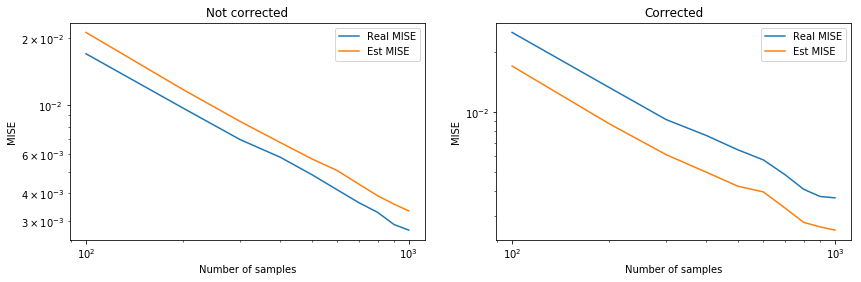

In [218]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
for ax, real, est in zip([ax1, ax2], [real_mise, real_mise_corr], [est_mise, est_mise_corr]):
    ax.loglog(nn, real, label="Real MISE")
    ax.loglog(nn, np.mean(est, axis=1), label="Est MISE")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("MISE")
    ax.legend()
ax1.set_title("Not corrected")
ax2.set_title("Corrected")

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


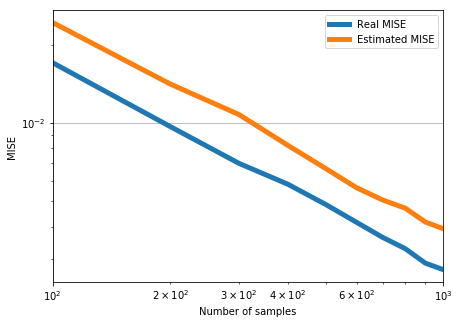

In [219]:
# Plot again the real MISE and the estimated MISE and export plot to tikz
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.loglog(nn, real_mise, label="Real MISE", lw=5)
ax.loglog(nn, est_mise[:, 0], label="Estimated MISE", lw=5)
ax.set_xlabel("Number of samples")
ax.set_ylabel("MISE")
ax.legend()
ax.grid(True)
ax.set_xlim([np.min(nn), np.max(nn)])
save(os.path.join('..', '20181002 Completeness question', 'figures', 'mise_example.tikz'),
     figureheight='\\figureheight', figurewidth='\\figurewidth')

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


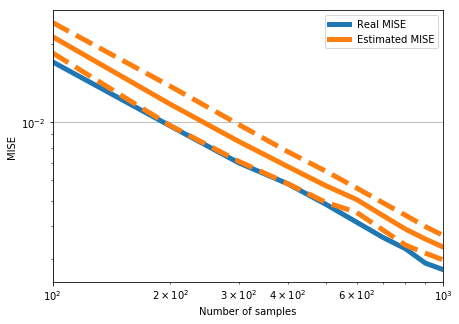

In [220]:
# Plot again the real MISE and the estimated MISE and export plot to tikz
f, ax = plt.subplots(1, 1, figsize=(7, 5))
est_mean = np.mean(est_mise, axis=1)
est_std = np.std(est_mise, axis=1)
ax.loglog(nn, real_mise, label="Real MISE", lw=5)
p = ax.loglog(nn, est_mean, label="Estimated MISE", lw=5)
ax.loglog(nn, est_mean+2*est_std, '--', color=p[0].get_color(), lw=5)
ax.loglog(nn, est_mean-2*est_std, '--', color=p[0].get_color(), lw=5)
ax.set_xlabel("Number of samples")
ax.set_ylabel("MISE")
ax.legend()
ax.grid(True)
ax.set_xlim([np.min(nn), np.max(nn)])
save(os.path.join('..', '20181002 Completeness question', 'figures', 'mise_example2.tikz'),
     figureheight='\\figureheight', figurewidth='\\figurewidth')

# Show that MISE can be used to use for two distributions

In [188]:
# Parameters
nmax = 5000
nmin = 100
nstep = 100
seed = 0
nrepeat = 100
overwrite = True

In [189]:
# Generate data
np.random.seed(seed)
A = gm.generate_samples(nmax*nrepeat).reshape((nrepeat, nmax))
B = gmb.generate_samples(nmax*nrepeat).reshape((nrepeat, nmax))
AB = np.concatenate((A[:, :, np.newaxis], B[:, :, np.newaxis]), axis=2)
nn = np.arange(nmin, nmax+nstep, nstep)

In [190]:
# Create the real pdfs
(xpdf,), ypdfa = gm.pdf(minx=[xlim[0]], maxx=[xlim[1]], n=npdf)
_, ypdfb = gmb.pdf(minx=[xlim[0]], maxx=[xlim[1]], n=npdf)
ypdfab = np.dot(ypdfb[:, np.newaxis], ypdfa[np.newaxis, :])

In [191]:
filename = os.path.join("hdf5", "mise_2d.hdf5")
if overwrite or not os.path.exists(filename):
    pdfa_est = np.zeros((len(nn), nrepeat, len(xpdf)))
    pdfb_est = np.zeros_like(pdfa_est)
    pdfab_est = np.zeros((len(nn), nrepeat, len(xpdf), len(xpdf)))
    bwa = np.zeros(len(nn))
    bwb = np.zeros_like(bwa)
    bwab = np.zeros_like(bwa)
    
    # We use the first set of datapoints (i.e., X[0]) for determining the bandwidth
    # This has quite some influence on the remainder of the procedure...
    i_bw = 0
    
    # For now, just set the data for all the kdes
    print("Initialize all {:d} KDEs".format(nrepeat))
    kdesa = [KDE(data=x) for x in A]
    kdesb = [KDE(data=x) for x in B]
    kdesab = [KDE(data=x) for x in AB]
    for kdea, kdeb, kdeab in tqdm(zip(kdesa, kdesb, kdesab)):
        kdea.set_score_samples(xpdf)
        kdeb.set_score_samples(xpdf)
        kdeab.set_score_samples(xpdf2)
    
    # Compute the bandwidths
    print("Compute the bandwidths")
    for i, n in enumerate(tqdm(nn)):
        # Compute the optimal bandwidth using 1-leave-out
        kdesa[i_bw].set_n(n)
        kdesa[i_bw].compute_bw()
        bwa[i] = kdesa[i_bw].bw
        kdesb[i_bw].set_n(n)
        kdesb[i_bw].compute_bw()
        bwb[i] = kdesb[i_bw].bw
        kdesab[i_bw].set_n(n)
        kdesab[i_bw].compute_bw()
        bwab[i] = kdesab[i_bw].bw
        
    # Compute all the nrepeats pdfs. We need to do this many times in order to determine the real MISE.
    print("Estimate pdfs")
    for j in tqdm(range(nrepeat)):
        for i, n in enumerate(nn):
            kdesa[j].set_n(n)
            kdesa[j].set_bw(bwa[i])
            pdfa_est[i, j] = kdesa[j].score_samples()
            kdesb[j].set_n(n)
            kdesb[j].set_bw(bwb[i])
            pdfb_est[i, j] = kdesb[j].score_samples()
            kdesab[j].set_n(n)
            kdesab[j].set_bw(bwab[i])
            pdfab_est[i, j] = kdesab[j].score_samples()
    
    # Write results to hdf5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("xpdf", data=xpdf)
        f.create_dataset("xpdf2", data=xpdf2)
        f.create_dataset("pdfa_est", data=pdfa_est)
        f.create_dataset("pdfb_est", data=pdfb_est)
        f.create_dataset("pdfab_est", data=pdfab_est)
        f.create_dataset("bwa", data=bwa)
        f.create_dataset("bwb", data=bwb)
        f.create_dataset("bwab", data=bwab)
else:
    with h5py.File(filename, "r") as f:
        xpdf = f["xpdf"][:]
        xpdf2 = f["xpdf2"][:]
        pdfa_est = f["pdfa_est"][:]
        pdfb_est = f["pdfb_est"][:]
        pdfab_est = f["pdfab_est"][:]
        bwa = f["bwa"][:]
        bwb = f["bwb"][:]
        bwab = f["bwab"][:]

Initialize all 10 KDEs



Compute the bandwidths



Estimate pdfs


In [192]:
# Compute the real MISE and estimate the MISE
real_mise_dep = np.zeros(len(nn))  # Real MISE for multivariate KDE, i.e., data assumed to be dependent
est_mise_dep = np.zeros((len(nn), nrepeat))
real_mise_ind = np.zeros_like(real_mise_dep)  # Real MISE for when data is assumed to be independent
est_mise_ind = np.zeros_like(est_mise_dep)
muka = kdesa[0].muk
mukab = kdesab[0].muk
for i, (y, h, n) in enumerate(zip(pdfab_est, bwab, nn)):
    real_mise_dep[i] = np.trapz(np.trapz(np.mean((y - ypdfab)**2, axis=0), xpdf), xpdf)
    laplacian = (np.gradient(np.gradient(y, axis=1), axis=1) + 
                 np.gradient(np.gradient(y, axis=2), axis=2)) / dx**2
    integral_laplacian = np.trapz(np.trapz(laplacian**2, xpdf), xpdf)
    est_mise_dep[i] = mukab / (n * h**2) + integral_laplacian * h**4 / 4
    
for i, (ya, yb, ha, hb, n) in enumerate(zip(pdfa_est, pdfb_est, bwa, bwb, nn)):
    # Estimate the real MISE
    pdfab_ind = np.zeros((len(ya), len(xpdf), len(xpdf)))
    for j, (a, b) in enumerate(zip(ya, yb)):
        pdfab_ind[j] = np.dot(b[:, np.newaxis], a[np.newaxis, :])
    real_mise_ind[i] = np.trapz(np.trapz(np.mean((pdfab_ind - ypdfab)**2, axis=0), xpdf), xpdf)
    
    # Compute the MISE for pdf a
    laplaciana = np.gradient(np.gradient(ya, axis=1), axis=1) / dx**2
    integrala = np.trapz(laplaciana**2, xpdf)
    est_misea = muka / (n * ha) + integrala * ha**4 / 4
    
    # Compute the MISE for pdf b
    laplacianb = np.gradient(np.gradient(yb, axis=1), axis=1) / dx**2
    integralb = np.trapz(laplacianb**2, xpdf)
    est_miseb = muka / (n * hb) + integrala * hb**4 / 4
    
    # Compute the integrals of the squared probabilities
    integral_sqya = np.trapz(ya**2, xpdf)
    integral_sqyb = np.trapz(yb**2, xpdf)
    
    # Finally, estimate the MISE
    est_mise_ind[i] = integral_sqyb*est_misea + integral_sqya*est_miseb + est_misea*est_miseb

Text(0.5,1,'Assuming that data is dependent')

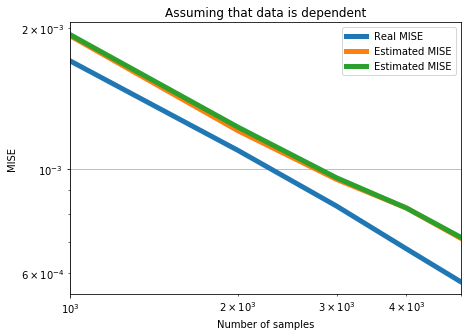

In [195]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.loglog(nn, real_mise_dep, lw=5, label="Real MISE")
ax.loglog(nn, est_mise_dep[:, 0], lw=5, label="Estimated MISE")
ax.set_xlabel("Number of samples")
ax.set_ylabel("MISE")
ax.legend()
ax.grid(True)
ax.set_xlim([np.min(nn), np.max(nn)])
ax.set_title("Assuming that data is dependent")

Text(0.5,1,'Assuming that data is independent')

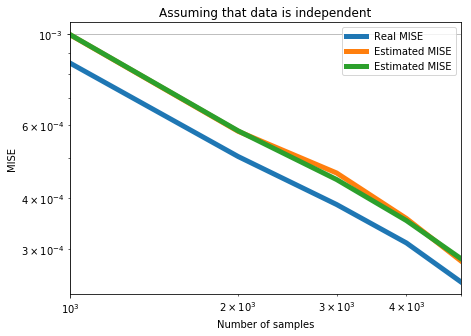

In [196]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.loglog(nn, real_mise_ind, lw=5, label="Real MISE")
ax.loglog(nn, est_mise_ind[:, 0], lw=5, label="Estimated MISE")
ax.set_xlabel("Number of samples")
ax.set_ylabel("MISE")
ax.legend()
ax.grid(True)
ax.set_xlim([np.min(nn), np.max(nn)])
ax.set_title("Assuming that data is independent")

# Show whether it is "better" to use multivariate distribution or not

In [94]:
# Parameters
n = 200
seed = 2
nrepeat = 100
npdf = 101
xlim = [-3, 3]
overwrite = True

In [95]:
# Generate data
np.random.seed(seed)
x = gm.generate_samples(n)
y = gm.generate_samples(n)
xy = np.concatenate((x, y), axis=1)

In [96]:
# Create the real pdfs
(xpdf,), ypdf_univar = gm.pdf(minx=[xlim[0]], maxx=[xlim[1]], n=npdf)
gm_multivar = GaussianMixture([[-1, -1], [-1, 1], [1, -1], [1, 1]], [np.diag([0.5, 0.5]), np.diag([0.5, 0.3]), 
                                                                     np.diag([0.3, 0.5]), np.diag([0.3, 0.3])])
(x1pdf, x2pdf), ypdf_multivar = gm_multivar.pdf(minx=[xlim[0], xlim[0]], maxx=[xlim[1], xlim[1]], n=npdf)

In [97]:
# Create three KDE (for x, y, and xy, respectively) and estimate MISE
kdex = KDE(data=x)
kdey = KDE(data=y)
kdexy = KDE(data=xy)
print("Description   Bandwidth   1LO Loglikelihood         MISE")
for kde, description in zip([kdex, kdey, kdexy], ['kdex', 'kdey', 'kdexy']):
    kde.compute_bw()
    print("{:>11s}   {:9.3f}   {:17.5f}   {:10.5f}".format(description, kde.bw, kde.score_leave_one_out(), 
                                                          kde.muk / (n * kde.bw**kde.d)))
bwx = kdex.bw
bwy = kdey.bw
bwxy = kdexy.bw

Description   Bandwidth   1LO Loglikelihood         MISE
       kdex       0.336          -125.27092      0.00420
       kdey       0.270          -114.51115      0.00522
      kdexy       0.385          -247.40787      0.00268


In [98]:
kdex.set_bw(0.025)
integral_laplacian_x = np.trapz((np.gradient(np.gradient(kdex.score_samples(xpdf))) / np.mean(np.gradient(xpdf))**2)**2, xpdf)
est_bias = kdex.bw**4 / 4 * integral_laplacian_x
est_bias

0.00018216471028668037

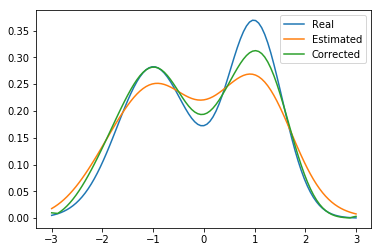

In [99]:
kdex.set_bw(0.5)
laplacian = np.gradient(np.gradient(kdex.score_samples(xpdf))) / np.mean(np.gradient(xpdf))**2
bias = laplacian * kdex.bw**2 / 2
plt.plot(xpdf, ypdf_univar, label="Real")
plt.plot(xpdf, kdex.score_samples(xpdf), label="Estimated")
plt.plot(xpdf, kdex.score_samples(xpdf) - bias, label="Corrected")
plt.legend()

In [100]:
# Compute the real MISE
filename = os.path.join("hdf5", "approx_mise.hdf5")

if overwrite or not os.path.exists(filename):
    pdfsx = np.zeros((nrepeat, len(xpdf)))
    pdfsy = np.zeros_like(pdfsx)
    pdfsxy = np.zeros((nrepeat, len(xpdf), len(xpdf)))
    pdfsxy2 = np.zeros((nrepeat, len(xpdf), len(xpdf)))
    for i in tqdm(range(nrepeat)):
        x = gm.generate_samples(n)
        y = gm.generate_samples(n)
        xy = np.concatenate((x, y), axis=1)
        kdex = KDE(data=x, bw=bwx)
        kdey = KDE(data=y, bw=bwy)
        kdexy = KDE(data=xy, bw=bwxy)
        pdfsx[i] = kdex.score_samples(xpdf)
        pdfsy[i] = kdey.score_samples(xpdf)
        pdfsxy[i] = kdexy.score_samples(xpdf2)
        pdfsxy2[i] = np.kron(pdfsx[i], pdfsy[i][:, np.newaxis])
    
    # Write results to hdf5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("pdfsx", data=pdfsx)
        f.create_dataset("pdfsy", data=pdfsy)
        f.create_dataset("pdfsxy", data=pdfsxy)
        f.create_dataset("pdfsxy2", data=pdfsxy2)
else:
    with h5py.File(filename, "r") as f:
        pdfsx = f["pdfsx"][:]
        pdfsy = f["pdfsy"][:]
        pdfsxy = f["pdfsxy"][:]
        pdfsxy2 = f["pdfsxy2"][:]

In [101]:
real_misex = np.trapz(np.mean((pdfsx - ypdf_univar)**2, axis=0), xpdf)
real_misey = np.trapz(np.mean((pdfsy - ypdf_univar)**2, axis=0), xpdf)
real_misexy = np.trapz(np.trapz(np.mean((pdfsxy - ypdf_multivar)**2, axis=0), xpdf), xpdf)
real_misexy2 = np.trapz(np.trapz(np.mean((pdfsxy2 - ypdf_multivar)**2, axis=0), xpdf), xpdf)
dx = np.mean(np.gradient(xpdf))
integral_laplacian_univar = np.trapz((np.gradient(np.gradient(ypdf_univar)) / dx**2)**2, xpdf)
integral_laplacian_multivar = np.trapz(np.trapz((np.gradient(np.gradient(ypdf_multivar, axis=0), axis=0) / dx**2 +
                                                 np.gradient(np.gradient(ypdf_multivar, axis=1), axis=1) / dx**2)**2, 
                                                xpdf), xpdf)
est_misex = kdex.muk / (n * bwx) + integral_laplacian_univar * bwx**4 / 4
est_misey = kdey.muk / (n * bwy) + integral_laplacian_univar * bwy**4 / 4
est_misexy = kdexy.muk / (n * bwxy**2) + integral_laplacian_multivar * bwxy**4 / 4
print("Description  Real MISE  MISE Formula")
for description, real, est in zip(['kdex', 'kdey', 'kdexy', 'extra'], [real_misex, real_misey, real_misexy, real_misexy2],
                                  [est_misex, est_misey, est_misexy, 
                                   np.trapz(ypdf_univar**2, xpdf) * (est_misex + est_misey) + est_misex*est_misey]):
    print("{:>11s}  {:9.5f}  {:12.5f}".format(description, real, est))

Description  Real MISE  MISE Formula
       kdex    0.00562       0.00829
       kdey    0.00487       0.00693
      kdexy    0.00446       0.00672
      extra    0.00259       0.00381


In [93]:
real_misex = np.trapz(np.mean((pdfsx - ypdf_univar)**2, axis=0), xpdf)
real_misey = np.trapz(np.mean((pdfsy - ypdf_univar)**2, axis=0), xpdf)
real_misexy = np.trapz(np.trapz(np.mean((pdfsxy - ypdf_multivar)**2, axis=0), xpdf), xpdf)
real_misexy2 = np.trapz(np.trapz(np.mean((pdfsxy2 - ypdf_multivar)**2, axis=0), xpdf), xpdf)
dx = np.mean(np.gradient(xpdf))
integral_laplacian_univar = np.trapz((np.gradient(np.gradient(ypdf_univar)) / dx**2)**2, xpdf)
integral_laplacian_multivar = np.trapz(np.trapz((np.gradient(np.gradient(ypdf_multivar, axis=0), axis=0) / dx**2 +
                                                 np.gradient(np.gradient(ypdf_multivar, axis=1), axis=1) / dx**2)**2, 
                                                xpdf), xpdf)
est_misex = kdex.muk / (n * bwx) + integral_laplacian_univar * bwx**4 / 4
est_misey = kdey.muk / (n * bwy) + integral_laplacian_univar * bwy**4 / 4
est_misexy = kdexy.muk / (n * bwxy**2) + integral_laplacian_multivar * bwxy**4 / 4
print("Description  Real MISE  MISE Formula")
for description, real, est in zip(['kdex', 'kdey', 'kdexy', 'extra'], [real_misex, real_misey, real_misexy, real_misexy2],
                                  [est_misex, est_misey, est_misexy, 
                                   np.trapz(ypdf_univar**2, xpdf) * (est_misex + est_misey) + est_misex*est_misey]):
    print("{:>11s}  {:9.5f}  {:12.5f}".format(description, real, est))

Description  Real MISE  MISE Formula
       kdex    0.00160       0.00193
       kdey    0.00162       0.00196
      kdexy    0.00179       0.00232
      extra    0.00081       0.00096
